<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/EEG_EDF_NN_autoencoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка и преобразование данных

In [ ]:
# установка библиотек
!pip install mne numpy
!pip install pywt
!pip install pyedflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 15.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import pywt
import mne


### Загрузка файла с гугл диска

In [ ]:
# путь к файлу на гугл-диске
edf_path = '/content/drive/MyDrive/edf_process/0001.edf'

# загрузка файла
raw = mne.io.read_raw_edf(edf_path, preload=True)


Extracting EDF parameters from /content/drive/MyDrive/edf_process/0001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 20607  =      0.000 ...   160.992 secs...


In [ ]:
# получим информацию о каналах
print(raw.info)

<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG Fp2, EEG F7, EEG F3, EEG Fz, EEG F4, EEG F8, EEG ...
 chs: 46 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: 2022-01-19 20:13:27 UTC
 nchan: 46
 projs: []
 sfreq: 128.0 Hz
>


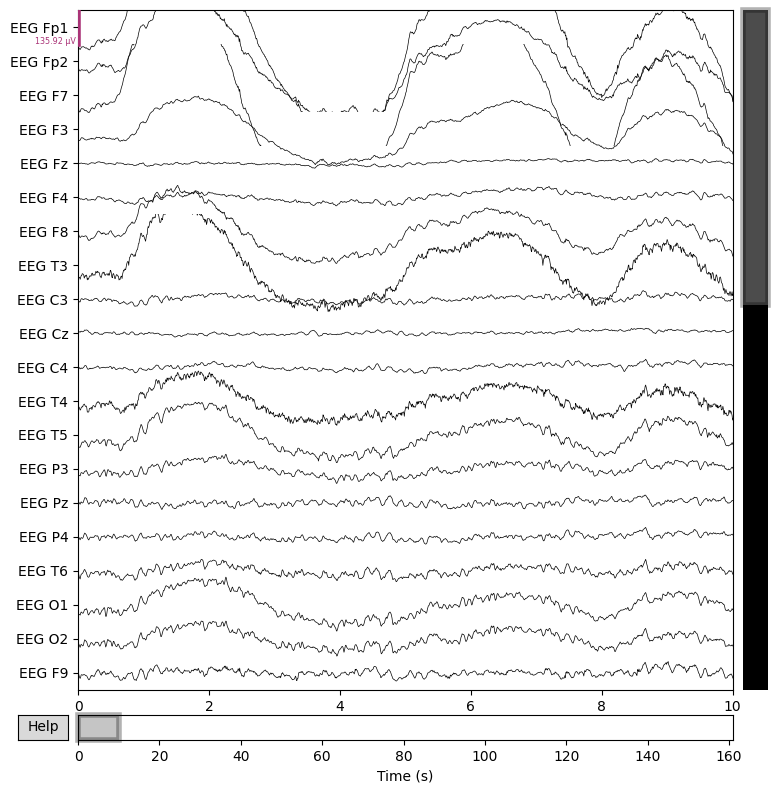

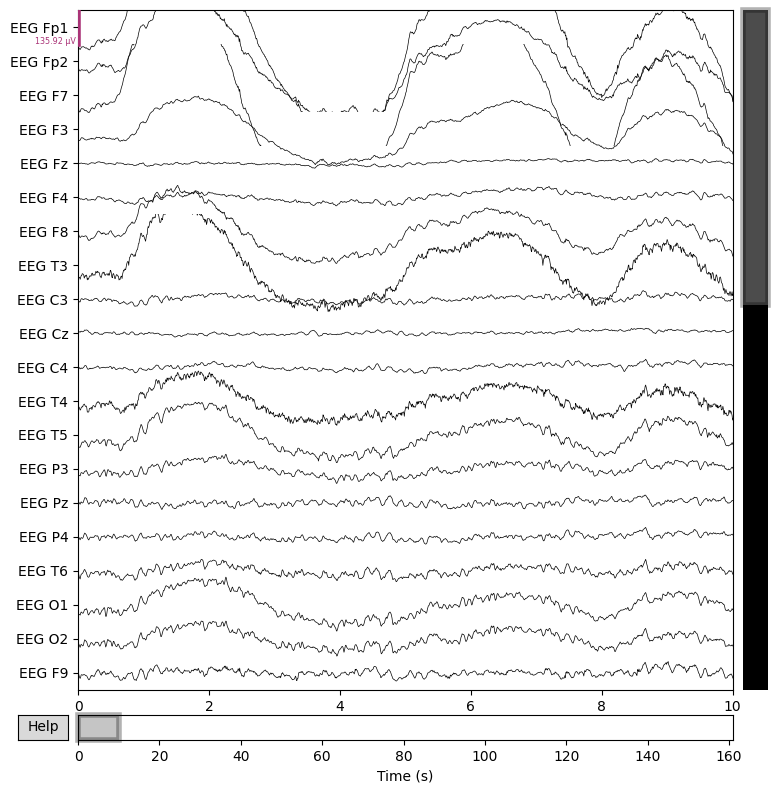

In [ ]:
raw.plot(scalings = 'auto', show = False)

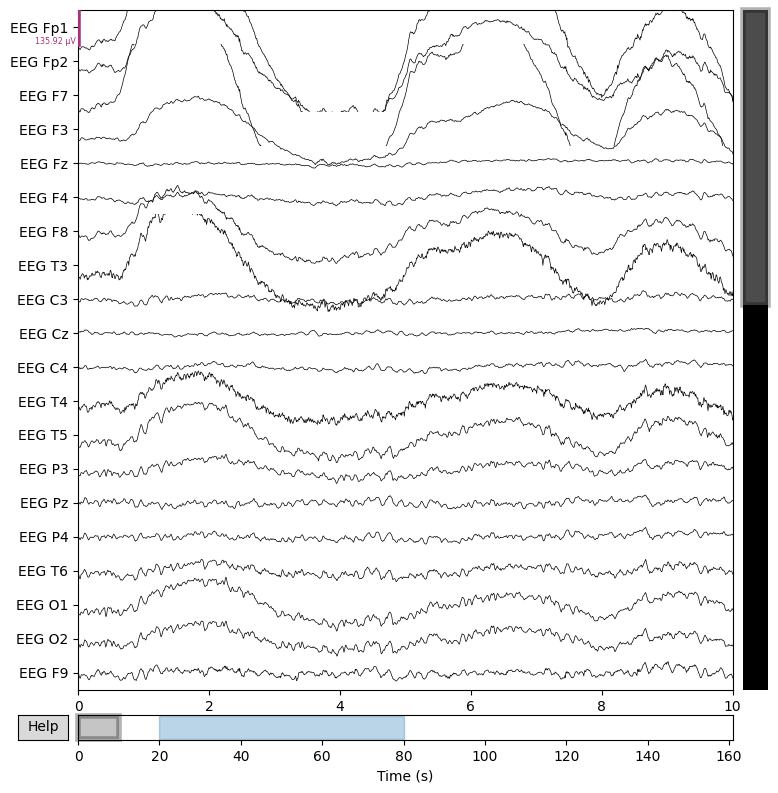

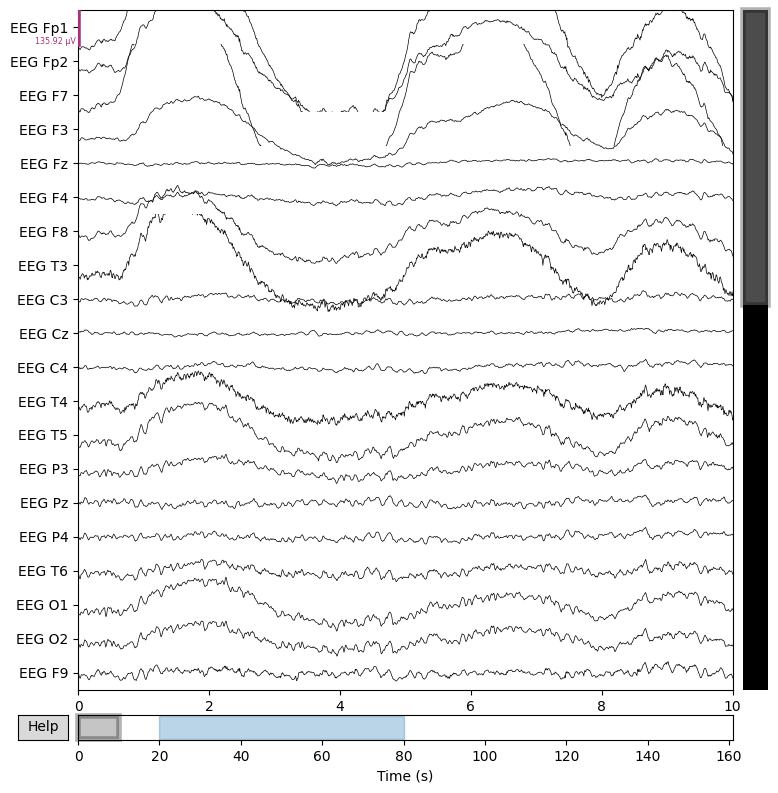

In [ ]:
new_annot = mne.Annotations(onset=20, duration=60, description="Example of annotation")
raw.set_annotations(new_annot)
raw.plot(scalings = 'auto', show = False)

In [ ]:
print(raw.ch_names)

['EEG Fp1', 'EEG Fp2', 'EEG F7', 'EEG F3', 'EEG Fz', 'EEG F4', 'EEG F8', 'EEG T3', 'EEG C3', 'EEG Cz', 'EEG C4', 'EEG T4', 'EEG T5', 'EEG P3', 'EEG Pz', 'EEG P4', 'EEG T6', 'EEG O1', 'EEG O2', 'EEG F9', 'EEG T9', 'EEG ECG', 'EEG P9', 'EEG F10', 'EEG T10', 'EEG P10', 'EEG AF3', 'EEG AF4', 'EEG FC1', 'EEG FC2', 'EEG FC5', 'EEG FC6', 'EEG CP1', 'EEG CP2', 'EEG CP5', 'EEG CP6', 'EEG PO3', 'EEG PO4', 'EEG EMG1', 'EEG EMG2', 'EEG EMG3', 'EEG EMG4', 'ECG thor+', 'ECG abdo+', 'ECG xyz+', 'Value MKR+']


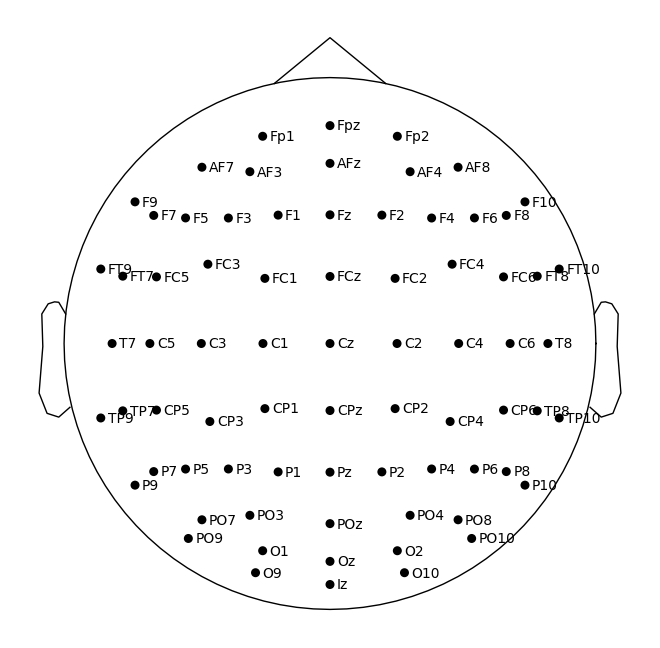

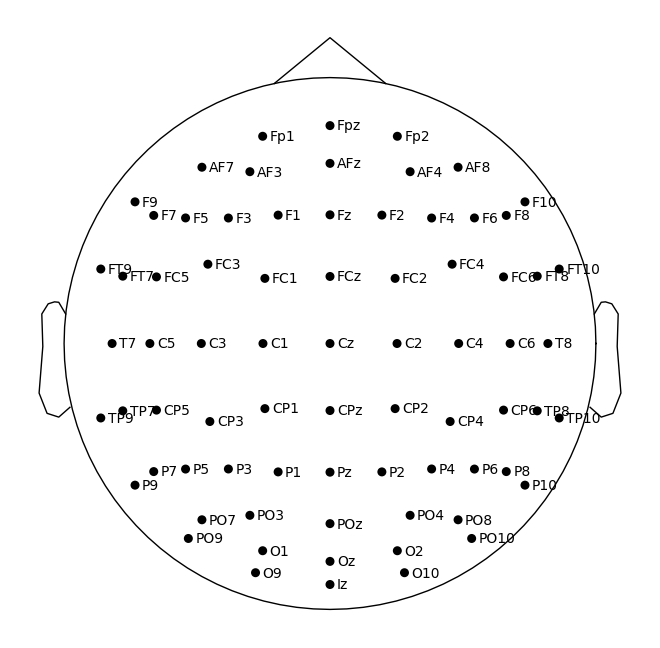

In [ ]:
easycap_montage = mne.channels.make_standard_montage("easycap-M1")
easycap_montage.plot(show = False)

In [ ]:
# Получить список имен каналов
channel_names = raw.ch_names

# Проверить, есть ли канал под номером 7
if len(channel_names) > 7:
    channel_7_name = channel_names[11]
    print("Имя канала под номером 7:", channel_7_name)
else:
    print("Канала под номером 7 не существует.")


Имя канала под номером 7: EEG T4


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-71-9b93a78d3f44>:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmin=0, fmax=50, picks=channel)


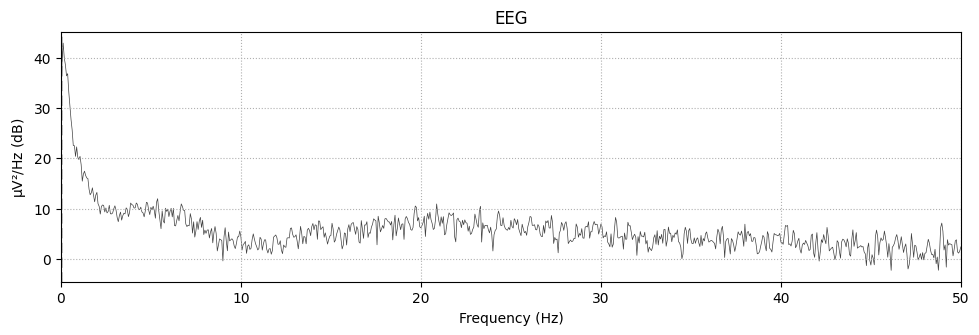

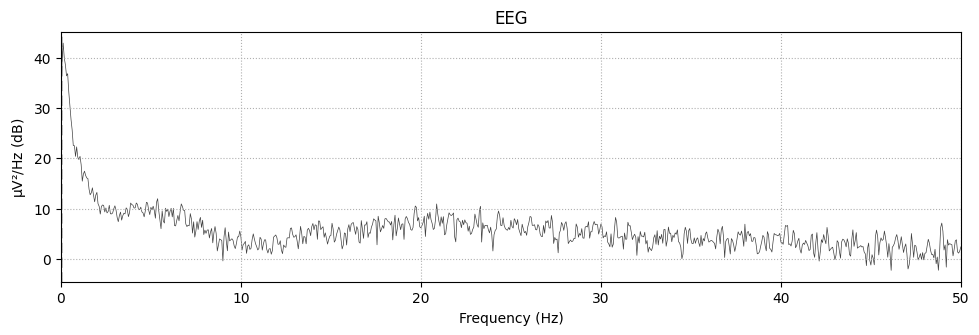

In [ ]:
# Задайте номер или имя канала
#channel = 'EEG Fz-G2'  # Номер канала или имя канала, например, 'Fz'
channel = channel_7_name  # Номер канала или имя канала, например, 'Fz'

# Построить PSD для одного канала
raw.plot_psd(fmin=0, fmax=50, picks=channel)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)


<ipython-input-39-fb2b99f7dc5b>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmin=0, fmax=50)


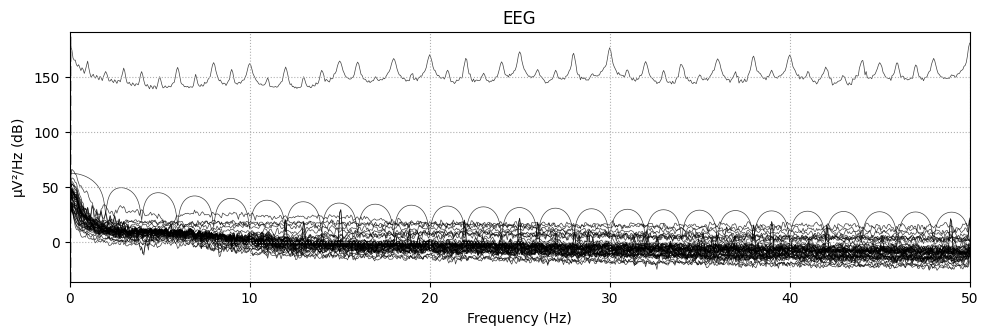

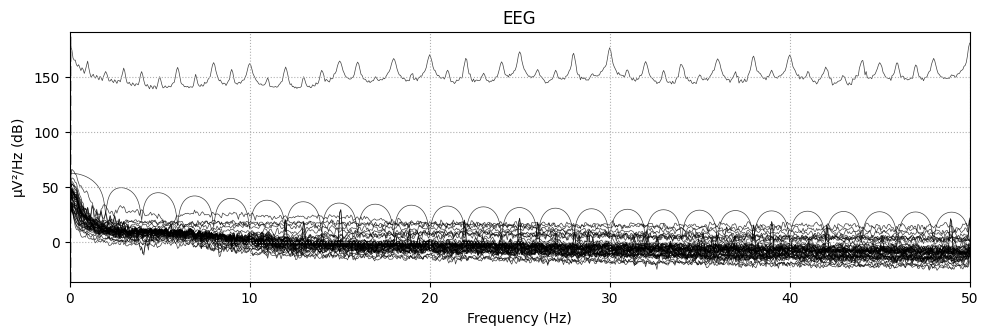

In [ ]:
raw.plot_psd(fmin=0, fmax=50)


## Фильтрация данных

In [ ]:
# извлечение сигналов ЭЭГ
#eeg_signals = raw.get_data(picks = 'eeg')
eeg_signals = raw.get_data()
print(eeg_signals.shape)

(46, 20608)


In [ ]:
eeg_data, eeg_times = raw.get_data(return_times=True)

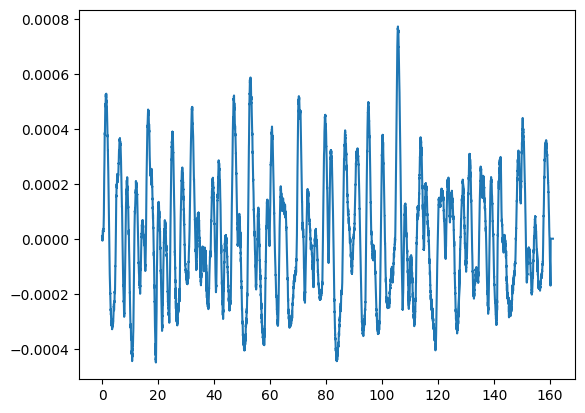

In [ ]:
plt.plot(eeg_times, eeg_data[2, :])
plt.show()

In [ ]:
# Фильтрация сигнала фильтром Баттерворта
filtered_raw = raw.copy().filter(0.5, 50, method='fir', fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [ ]:
# Прямая и обратная фильтрация
filtered_signal = filtered_raw.get_data(picks='eeg')
forward_filtered_signal = mne.filter.filter_data(filtered_signal, sfreq=raw.info['sfreq'], l_freq=None, h_freq=None, method='fir',
                                                 fir_window='hamming', fir_design='firwin2')
backward_filtered_signal = mne.filter.filter_data(forward_filtered_signal, sfreq=raw.info['sfreq'], l_freq=None, h_freq=None, method='fir',
                                                  fir_window='hamming', fir_design='firwin2', iir_params=None, picks=None, n_jobs=1)



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Filter length: 1 samples (0.008 s)



In [ ]:
# # Нормализация данных
# normalized_signal = (backward_filtered_signal - np.mean(backward_filtered_signal)) / np.std(backward_filtered_signal)

# info1 = mne.create_info(ch_names=raw.info['ch_names'], sfreq=raw.info['sfreq'], ch_types='eeg')
# raw_filt_po = mne.io.RawArray(backward_filtered_signal, info1)
# raw_filt_po.plot()
# # normalized_signal = (backward_filtered_signal - backward_filtered_signal.mean(axis=1, keepdims=True)) / backward_filtered_signal.std(axis=1, keepdims=True)

In [ ]:
# Вейвлет-преобразование Добеши 4 порядка, 6 уровней
wavelet = pywt.Wavelet('db4')
coeffs = pywt.wavedec(backward_filtered_signal, wavelet, level=6)

coeffs[1:] = [pywt.threshold(i, value=0, mode='soft') if i is not None else None for i in coeffs[1:]]
wavelet_filtered = pywt.waverec(coeffs, wavelet)

# # фильтруем данные
# wavelet_filtered = mne.filter.filter_data(wavelet_filtered, raw.info['sfreq'], l_freq=0.5, h_freq=50, verbose='ERROR')

info = mne.create_info(ch_names=raw.info['ch_names'], sfreq=raw.info['sfreq'], ch_types='eeg')
raw_filt = mne.io.RawArray(wavelet_filtered, info)

Creating RawArray with float64 data, n_channels=46, n_times=20608
    Range : 0 ... 20607 =      0.000 ...   160.992 secs
Ready.


## еще графики

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)


<ipython-input-48-0f01d6d9b1d5>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filt.plot_psd(fmin=0, fmax=50)


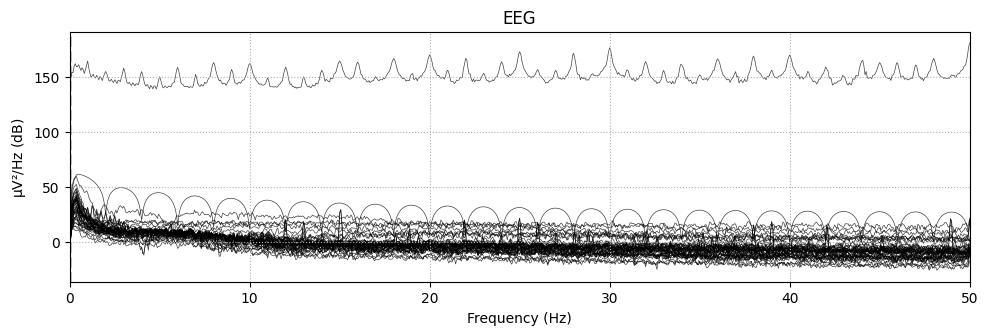

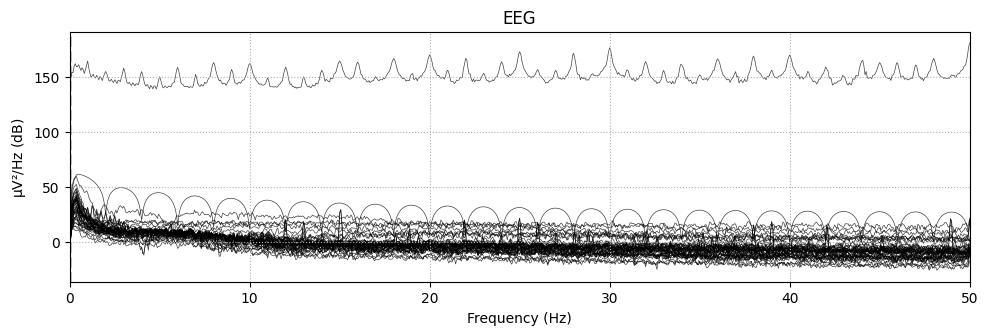

In [ ]:
raw_filt.plot_psd(fmin=0, fmax=50)


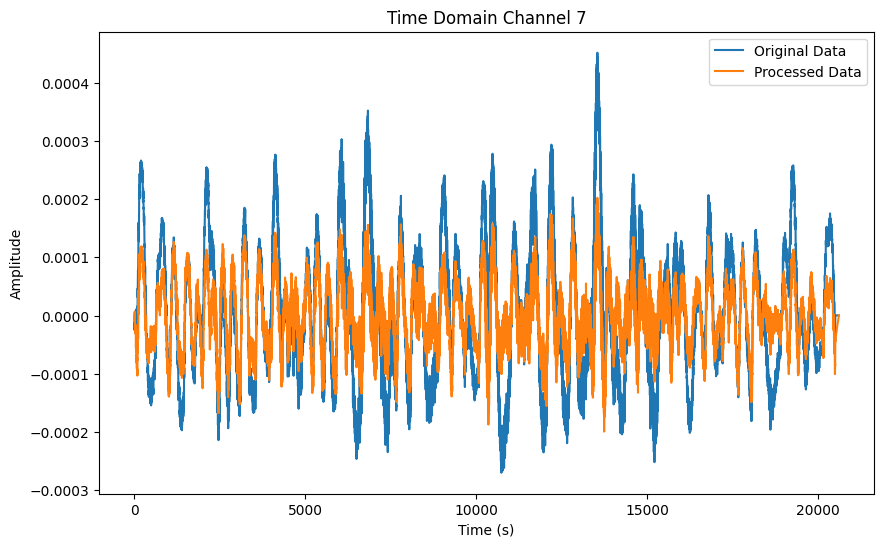

In [ ]:
# Выберите интересующий вас канал
channel_idx = 7

# Исходные данные
original_data = eeg_signals[channel_idx, :]
# original_power_spectrum, original_freqs = plt.psd(original_data, Fs=raw.info['sfreq'], NFFT=1024)

# Данные после фильтрации и вейвлет-преобразования
processed_data = wavelet_filtered[channel_idx, :]
# processed_power_spectrum, processed_freqs = plt.psd(processed_data, Fs=raw.info['sfreq'], NFFT=1024)

# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(original_data, label='Original Data')
plt.plot(processed_data, label='Processed Data')
plt.title('Time Domain Channel 7')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


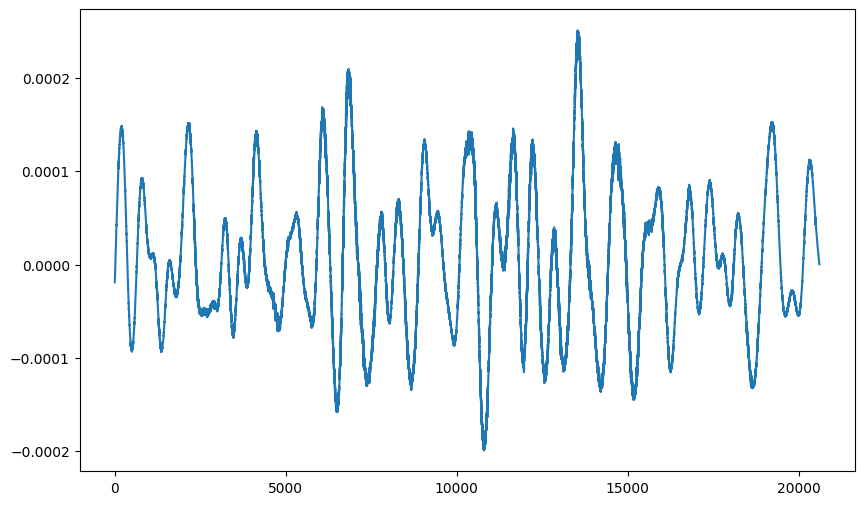

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(original_data - processed_data)
plt.show()

In [ ]:
Fs=raw.info['sfreq']
print(Fs)

128.0


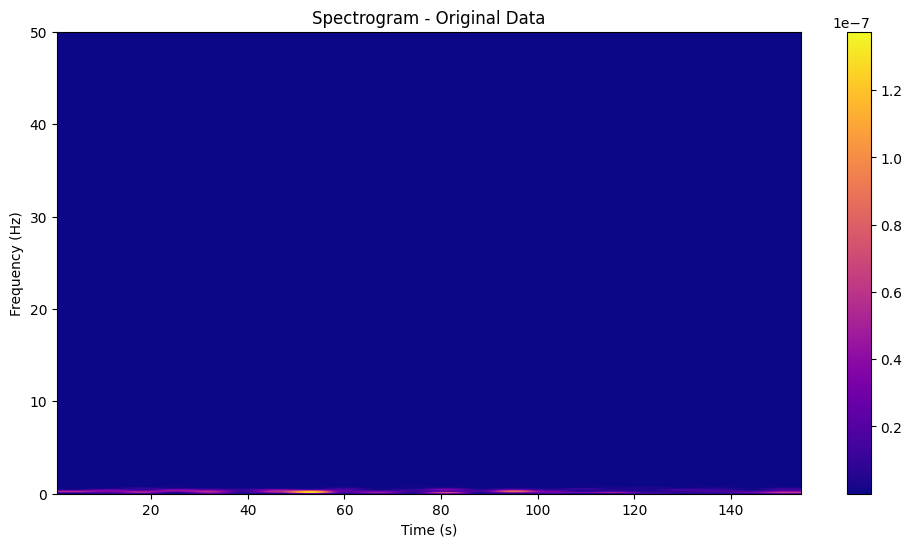

In [ ]:
# Выберите интересующий вас канал
channel_idx = 7

# Исходные данные
original_data = eeg_signals[channel_idx, :]

plt.figure(figsize=(12, 6))
#plt.specgram(original_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128, cmap='plasma')
plt.specgram(original_data, Fs=raw.info['sfreq'], NFFT = 1024, cmap='plasma', scale = 'linear',scale_by_freq = True)
plt.title('Spectrogram - Original Data')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, 50)
plt.colorbar()
plt.show()

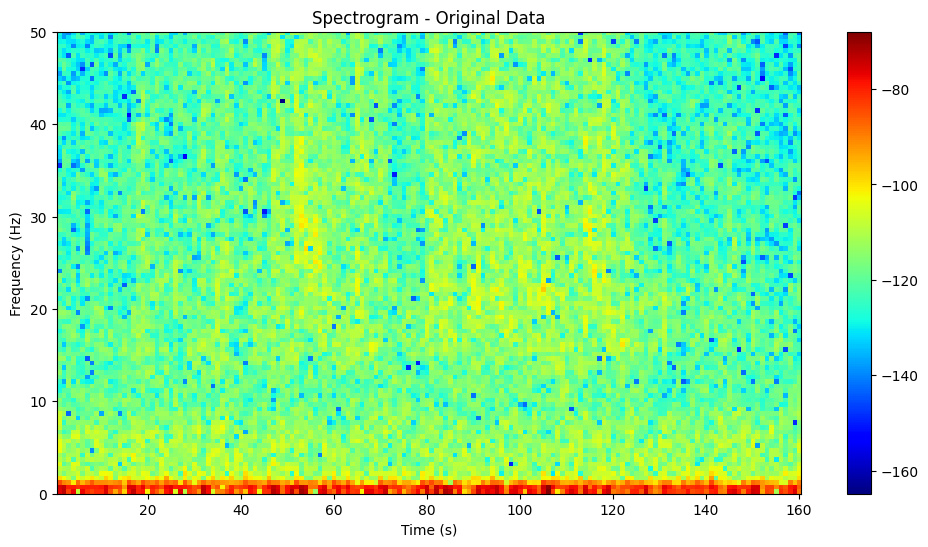

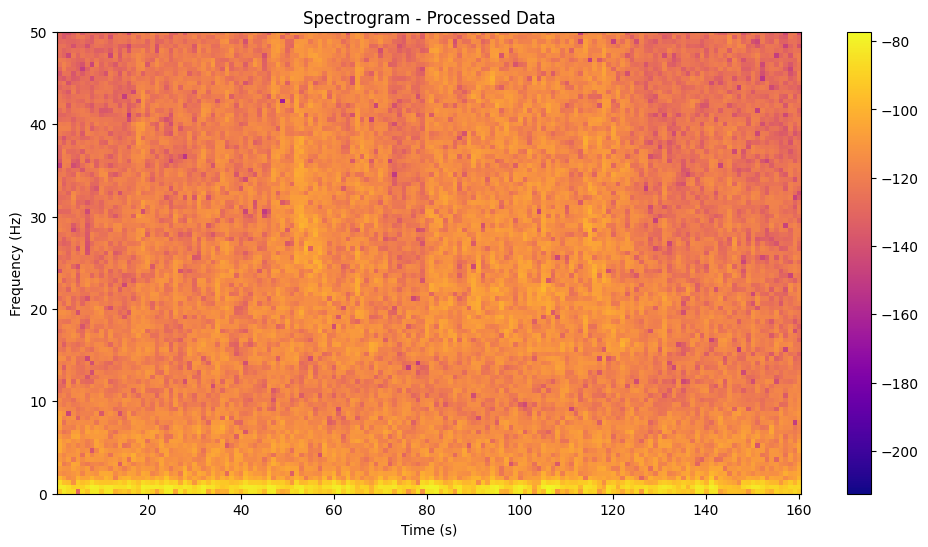

In [ ]:
# Выберите интересующий вас канал
channel_idx = 7

# Исходные данные
original_data = eeg_signals[channel_idx, :]
# original_power_spectrum, original_freqs = plt.psd(original_data, Fs=raw.info['sfreq'], NFFT=1024)

# Данные после фильтрации и вейвлет-преобразования
processed_data = wavelet_filtered[channel_idx, :]
# processed_power_spectrum, processed_freqs = plt.psd(processed_data, Fs=raw.info['sfreq'], NFFT=1024)
plt.figure(figsize=(12, 6))
plt.specgram(original_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128, cmap='jet')
plt.title('Spectrogram - Original Data')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, 50)
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 6))
plt.specgram(processed_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128, cmap='plasma')
plt.title('Spectrogram - Processed Data')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.ylim(0, 50)
plt.show()


## когерентность

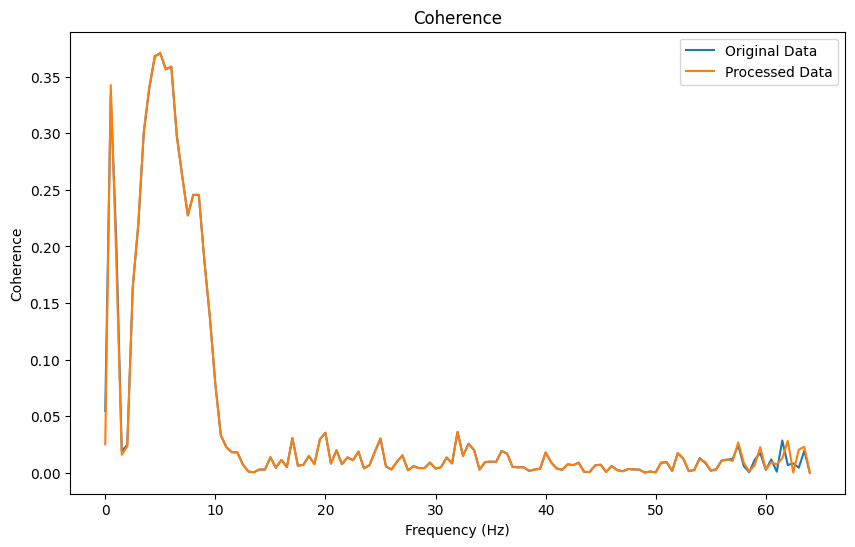

In [ ]:
import scipy.signal as signal

# Выберите два интересующих вас канала
channel1_idx = 7
channel2_idx = 10

# Исходные данные
original_data1 = eeg_signals[channel1_idx, :]
original_data2 = eeg_signals[channel2_idx, :]
original_frequencies, original_coherence = signal.coherence(original_data1, original_data2, fs=raw.info['sfreq'])

# Данные после фильтрации и вейвлет-преобразования
processed_data1 = wavelet_filtered[channel1_idx, :]
processed_data2 = wavelet_filtered[channel2_idx, :]
processed_frequencies, processed_coherence = signal.coherence(processed_data1, processed_data2, fs=raw.info['sfreq'])

# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(original_frequencies, original_coherence, label='Original Data')
plt.plot(processed_frequencies, processed_coherence, label='Processed Data')
plt.title('Coherence')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.legend()
plt.show()


# Построение характеристик для одного канала

## исходный

In [ ]:
# Выделение и построение характеристик для одного канала
channel_idx = 7  # Индекс интересующего канала
channel_data = eeg_signals[channel_idx, :]

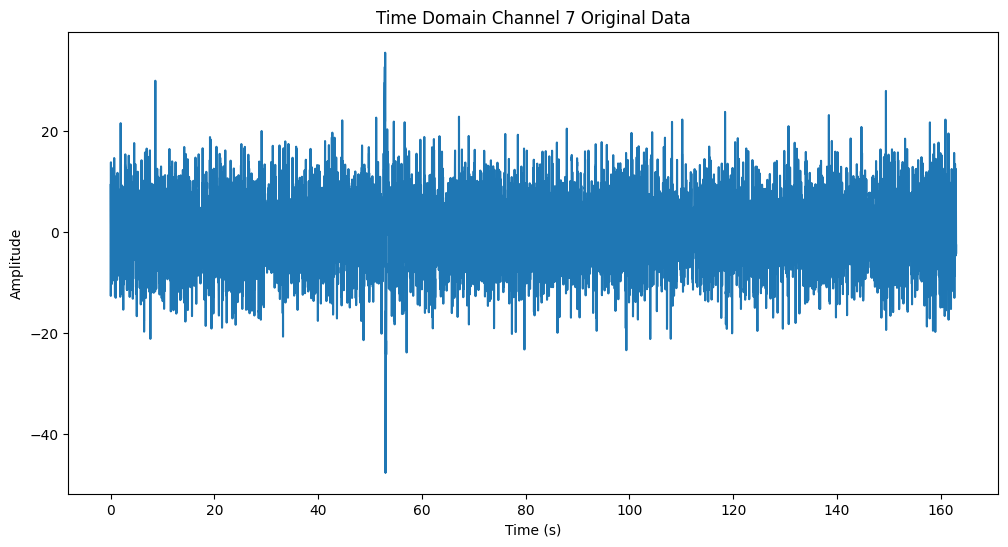

In [ ]:
# Временная характеристика
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(channel_data)) / raw.info['sfreq'], channel_data)
plt.title('Time Domain Channel 7 Original Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


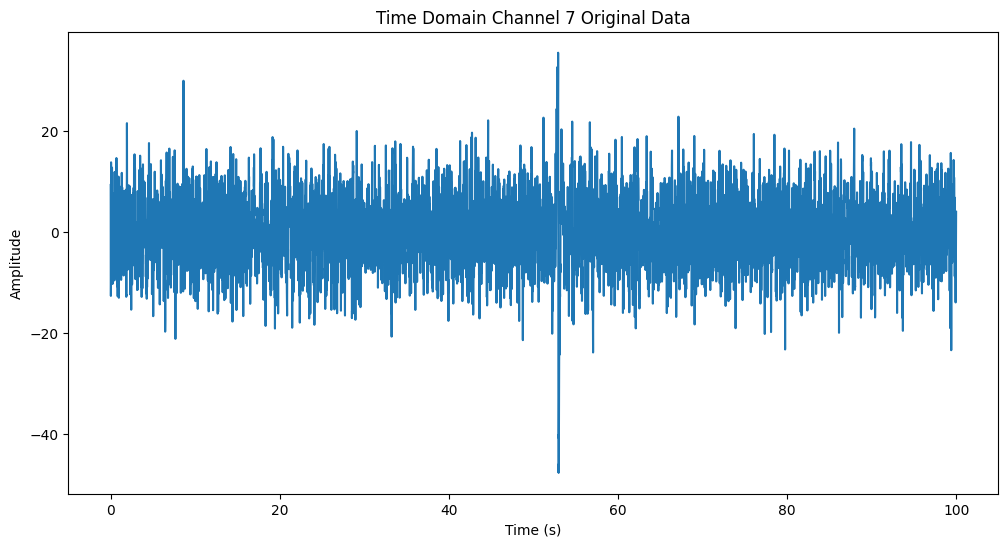

In [ ]:
# Установка границ времени для отображения данных
start_time = 0  # Начальное время в секундах
end_time = 100  # Конечное время в секундах

# Выделение соответствующего среза данных
time_slice = np.arange(int(start_time * raw.info['sfreq']), int(end_time * raw.info['sfreq']))
channel_data_slice = channel_data[time_slice]

# Временная характеристика
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(channel_data_slice)) / raw.info['sfreq'], channel_data_slice)
plt.title('Time Domain Channel 7 Original Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

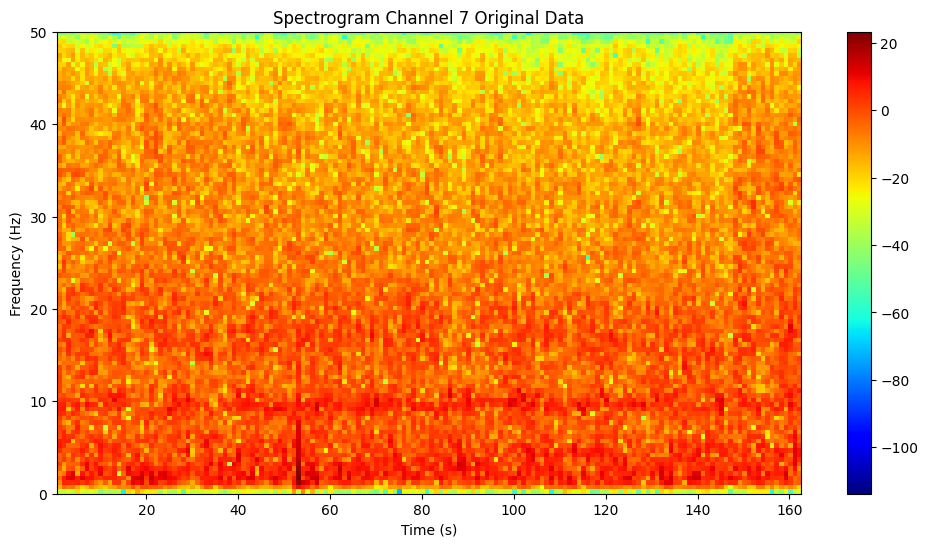

In [ ]:
# Частотно-временная характеристика
plt.figure(figsize=(12, 6))
plt.specgram(channel_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128, cmap='jet')
plt.title('Spectrogram Channel 7 Original Data')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.ylim(0, 50)
plt.show()

# # Частотно-временная характеристика
# plt.figure(figsize=(12, 6))
# Pxx, freqs, bins, im = plt.specgram(channel_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128, cmap='jet')
# plt.title('Spectrogram Channel 7 Original Data')
# plt.xlabel('Time (s)')
# plt.ylabel('Frequency (Hz)')
# plt.colorbar(im).set_label('Amplitude')
# plt.ylim(0, 50)  # Ограничение частотного диапазона до 50 Гц
# plt.show()


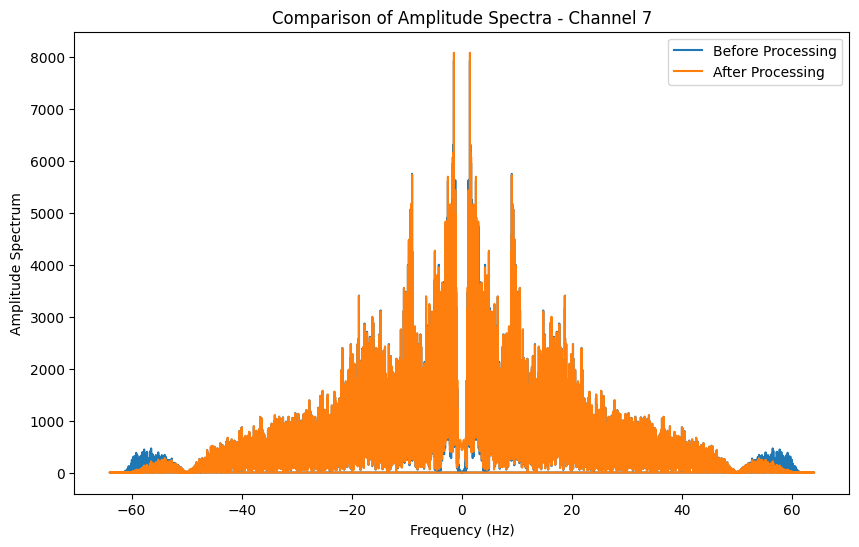

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# Сигнал до обработки (весь сигнал)
signal_before = eeg_signals # Замените на ваш сигнал до обработки
sampling_rate = raw.info['sfreq']  # Замените на частоту дискретизации сигнала

# Сигнал после обработки (весь сигнал)
signal_after = wavelet_filtered  # Замените на ваш сигнал после обработки

# Выделение одного канала
channel_index = 7  # Замените на индекс нужного канала
channel_before = signal_before[channel_index]
channel_after = signal_after[channel_index]

# Вычисление амплитудных спектров
freq_before = np.fft.fftfreq(len(channel_before), 1 / sampling_rate)
amp_spectrum_before = np.abs(fft(channel_before))
freq_after = np.fft.fftfreq(len(channel_after), 1 / sampling_rate)
amp_spectrum_after = np.abs(fft(channel_after))

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(freq_before, amp_spectrum_before, label='Before Processing')
plt.plot(freq_after, amp_spectrum_after, label='After Processing')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectrum')
plt.title(f'Comparison of Amplitude Spectra - Channel {channel_index}')
plt.legend()
plt.show()


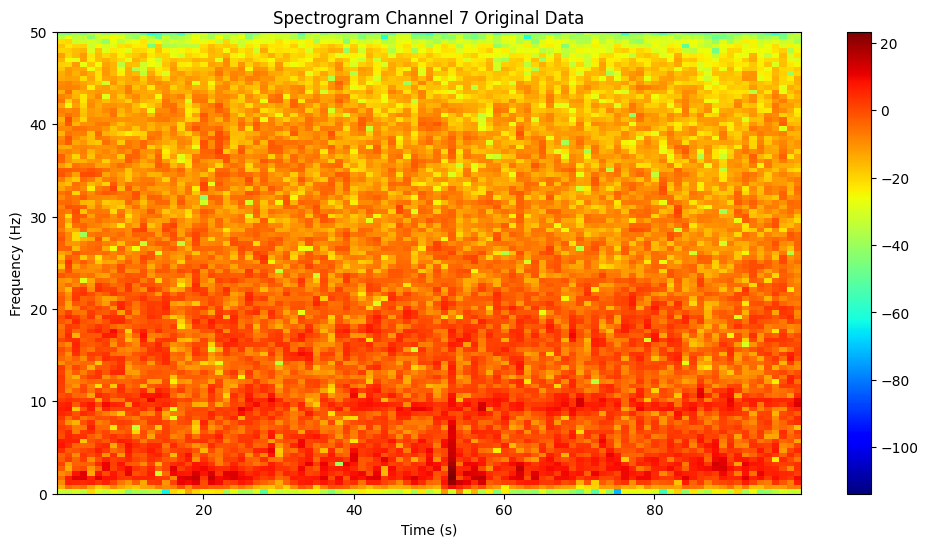

In [ ]:
# Установка границ времени для отображения данных
start_time = 0  # Начальное время в секундах
end_time = 100  # Конечное время в секундах

# Выделение соответствующего среза данных
time_slice = np.arange(int(start_time * raw.info['sfreq']), int(end_time * raw.info['sfreq']))
channel_data_slice = channel_data[time_slice]

# Частотно-временная характеристика
plt.figure(figsize=(12, 6))
plt.specgram(channel_data_slice, Fs=raw.info['sfreq'], NFFT=256, noverlap=128, cmap='jet')
plt.title('Spectrogram Channel 7 Original Data')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.ylim(0, 50)
plt.show()


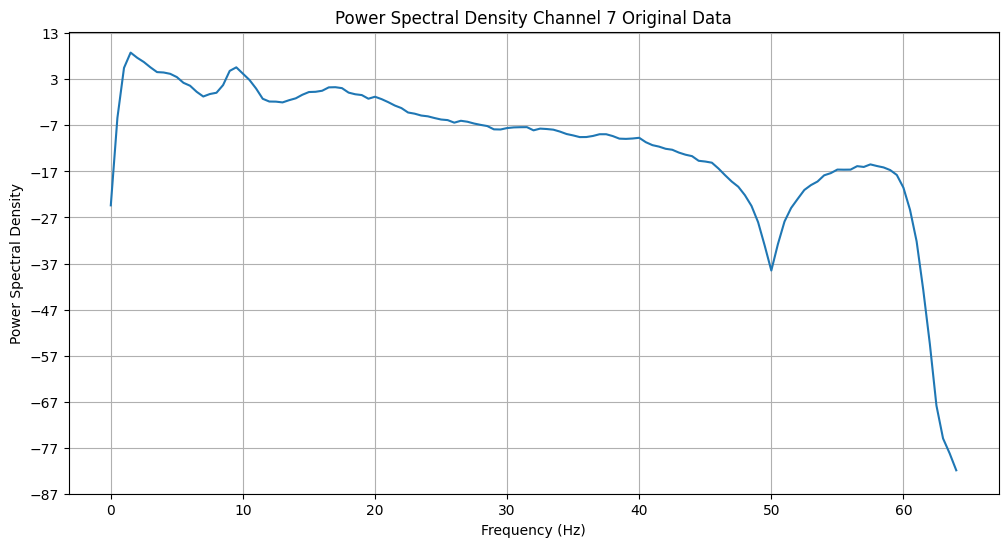

In [ ]:
plt.figure(figsize=(12, 6))
plt.psd(channel_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128)
plt.title('Power Spectral Density Channel 7 Original Data'.format(channel_idx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.grid(True)
plt.show()

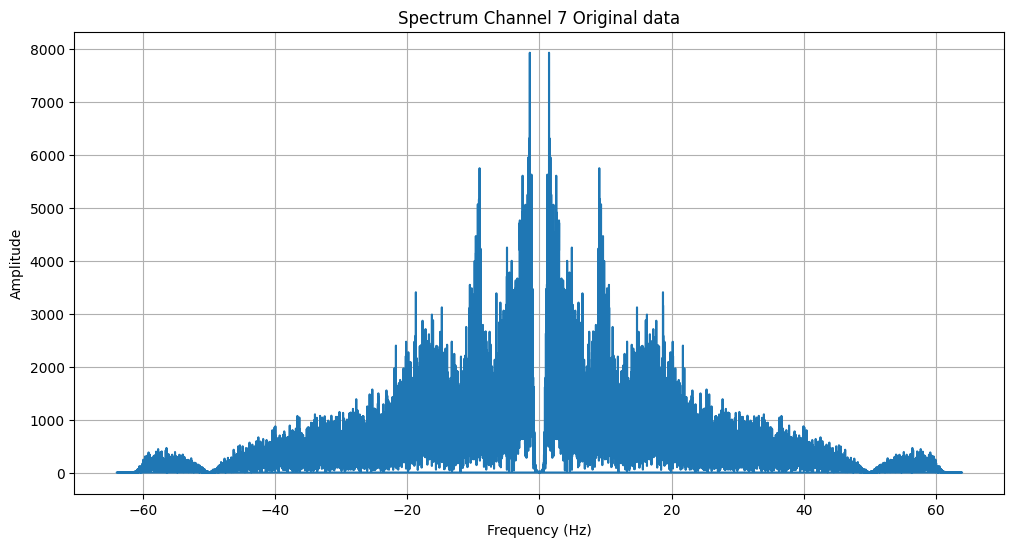

In [ ]:
fft_values = np.fft.fft(channel_data)
freq_values = np.fft.fftfreq(len(channel_data), d=1/raw.info['sfreq'])

plt.figure(figsize=(12, 6))
plt.plot(freq_values, np.abs(fft_values))
plt.title('Spectrum Channel {} Original data'.format(channel_idx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



## после баттерворта

In [ ]:
# Выделение и построение характеристик для одного канала
channel_idx = 8  # Индекс интересующего канала
channel_data = filtered_signal[channel_idx, :]

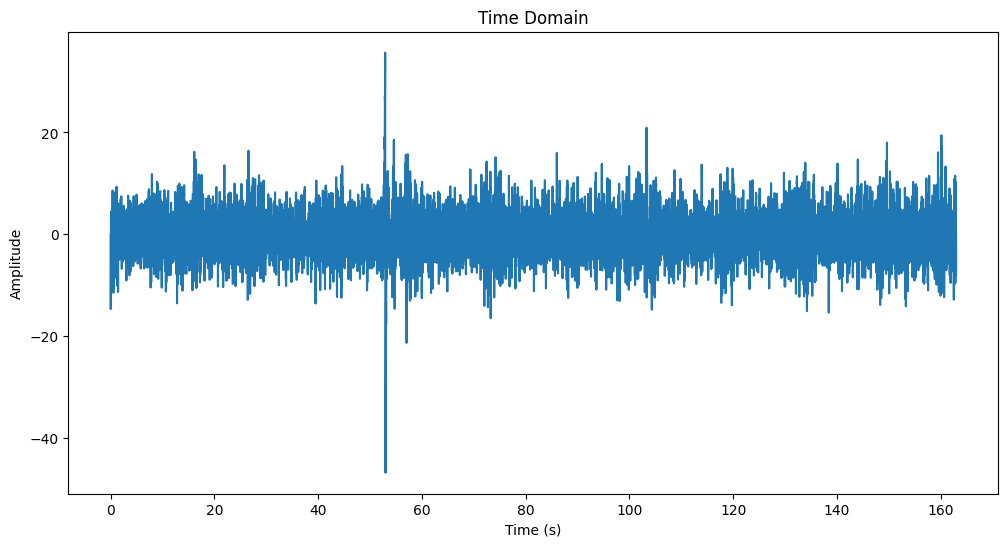

In [ ]:
# Временная характеристика
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(channel_data)) / raw.info['sfreq'], channel_data)
plt.title('Time Domain')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


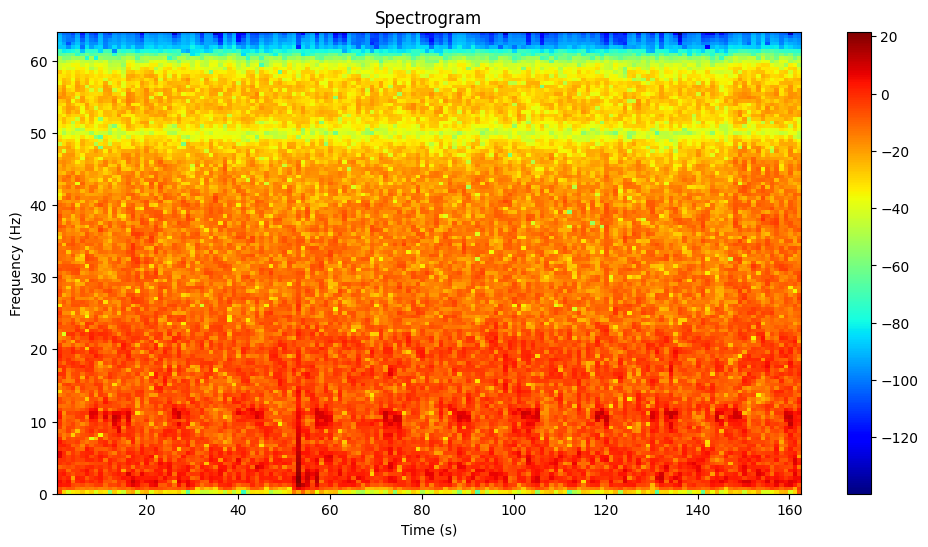

In [ ]:
# Частотно-временная характеристика
plt.figure(figsize=(12, 6))
plt.specgram(channel_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128, cmap='jet')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.show()


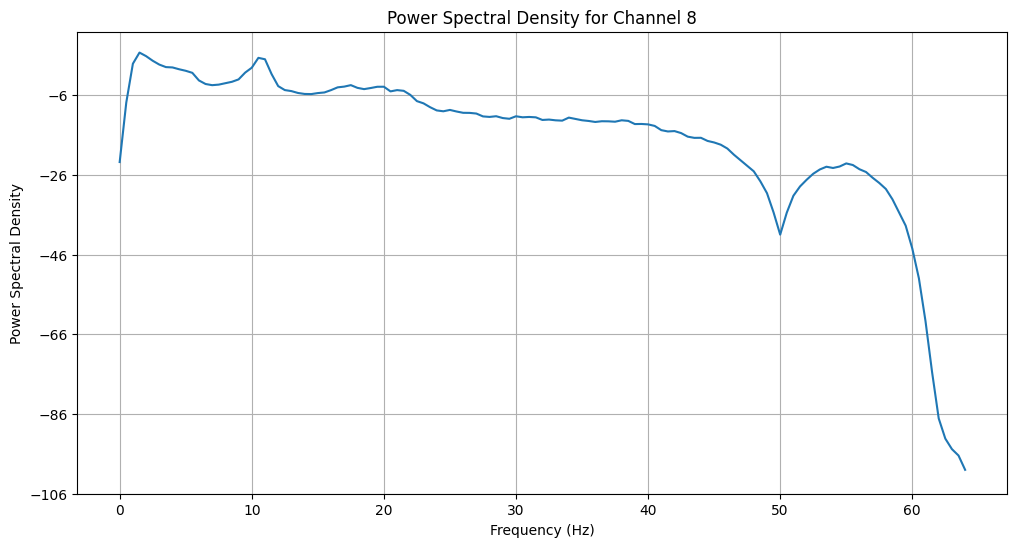

In [ ]:
plt.figure(figsize=(12, 6))
plt.psd(channel_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128)
plt.title('Power Spectral Density for Channel {}'.format(channel_idx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.grid(True)
plt.show()

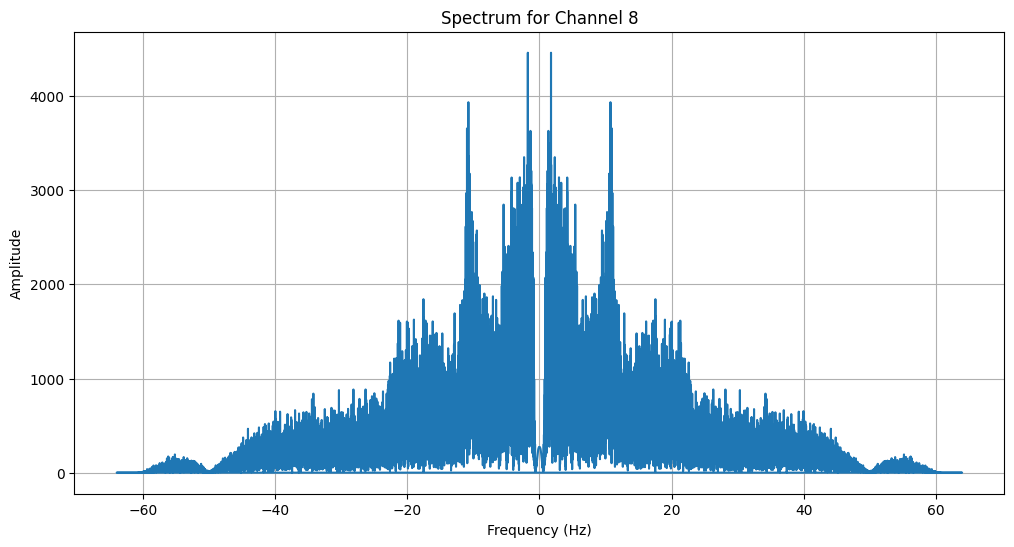

In [ ]:
fft_values = np.fft.fft(channel_data)
freq_values = np.fft.fftfreq(len(channel_data), d=1/raw.info['sfreq'])

plt.figure(figsize=(12, 6))
plt.plot(freq_values, np.abs(fft_values))
plt.title('Spectrum for Channel {}'.format(channel_idx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



## после прямой и обратной фильтрации

In [ ]:
# Выделение и построение характеристик для одного канала
channel_idx = 8  # Индекс интересующего канала
channel_data = backward_filtered_signal[channel_idx, :]

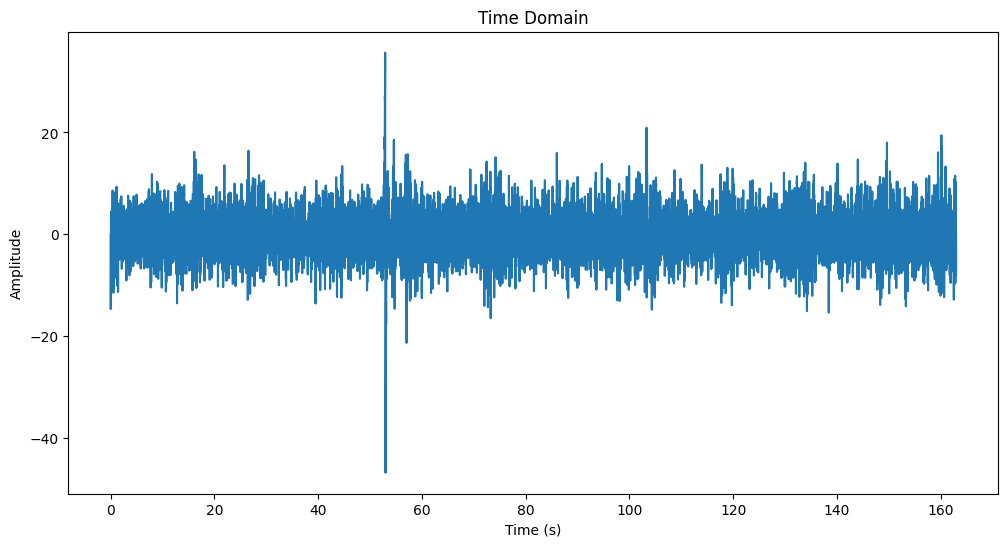

In [ ]:
# Временная характеристика
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(channel_data)) / raw.info['sfreq'], channel_data)
plt.title('Time Domain')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


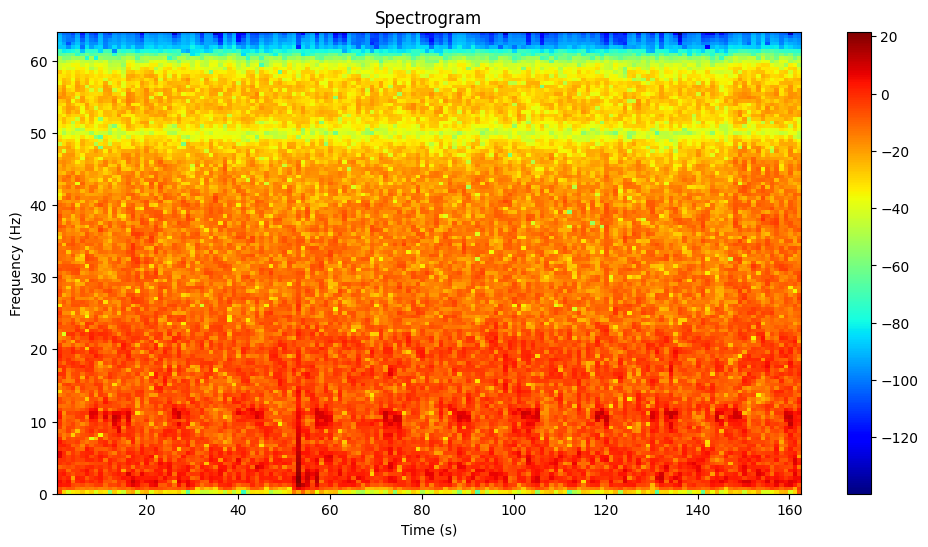

In [ ]:
# Частотно-временная характеристика
plt.figure(figsize=(12, 6))
plt.specgram(channel_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128, cmap='jet')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.show()


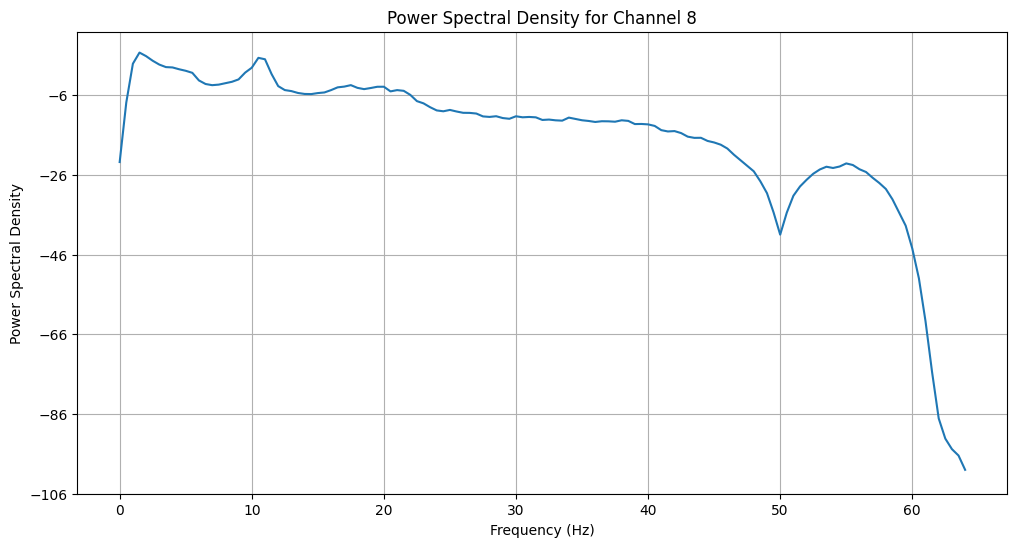

In [ ]:
plt.figure(figsize=(12, 6))
plt.psd(channel_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128)
plt.title('Power Spectral Density for Channel {}'.format(channel_idx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.grid(True)
plt.show()

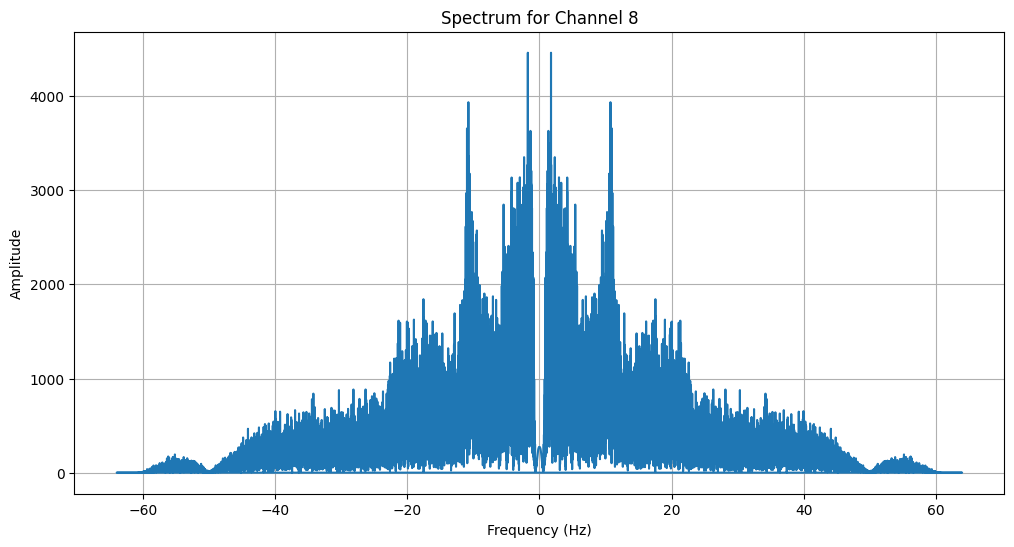

In [ ]:
fft_values = np.fft.fft(channel_data)
freq_values = np.fft.fftfreq(len(channel_data), d=1/raw.info['sfreq'])

plt.figure(figsize=(12, 6))
plt.plot(freq_values, np.abs(fft_values))
plt.title('Spectrum for Channel {}'.format(channel_idx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



## после нормализации

In [ ]:
# Выделение и построение характеристик для одного канала
channel_idx = 8  # Индекс интересующего канала
channel_data = normalized_signal[channel_idx, :]

NameError: ignored

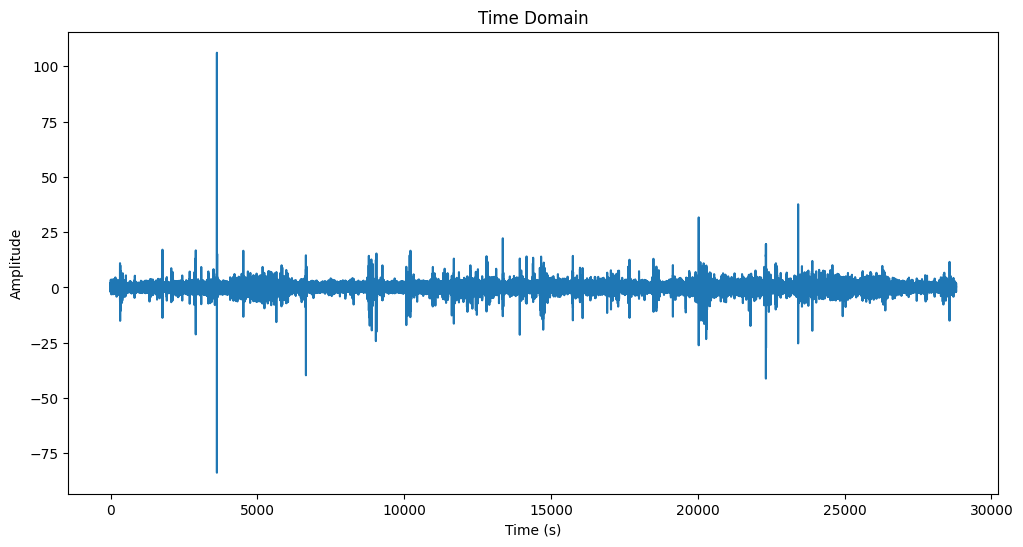

In [ ]:
# Временная характеристика
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(channel_data)) / raw.info['sfreq'], channel_data)
plt.title('Time Domain')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


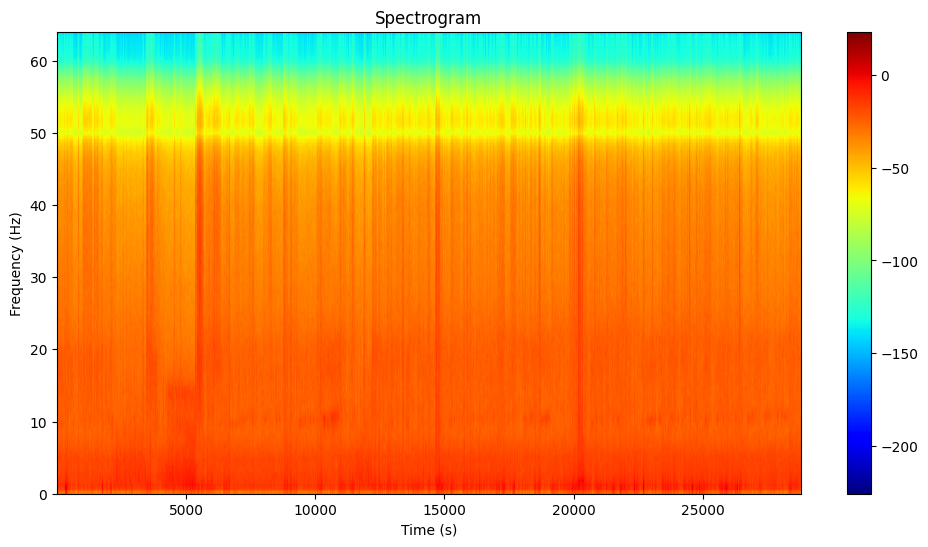

In [ ]:
# Частотно-временная характеристика
plt.figure(figsize=(12, 6))
plt.specgram(channel_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128, cmap='jet')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.show()


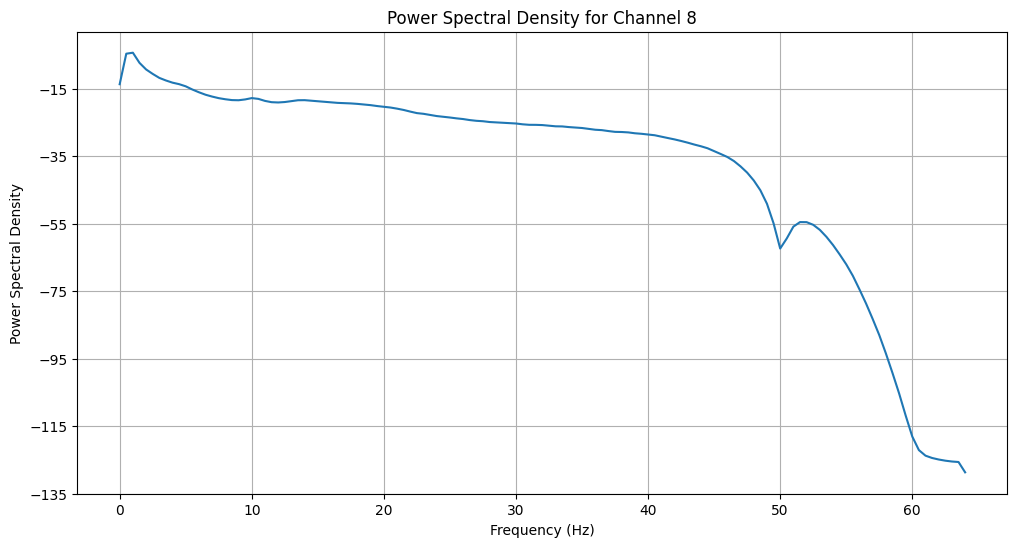

In [ ]:
plt.figure(figsize=(12, 6))
plt.psd(channel_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128)
plt.title('Power Spectral Density for Channel {}'.format(channel_idx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.grid(True)
plt.show()

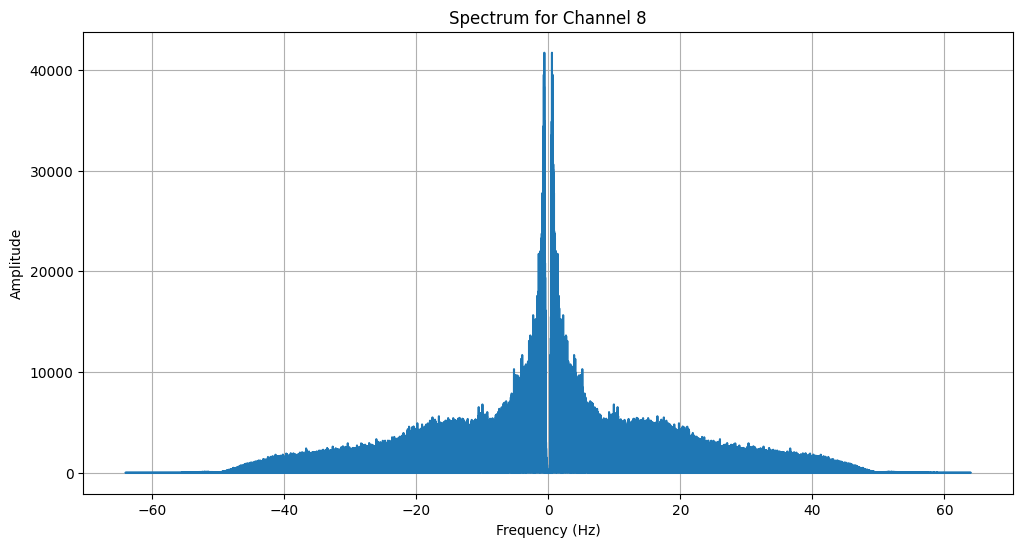

In [ ]:
fft_values = np.fft.fft(channel_data)
freq_values = np.fft.fftfreq(len(channel_data), d=1/raw.info['sfreq'])

plt.figure(figsize=(12, 6))
plt.plot(freq_values, np.abs(fft_values))
plt.title('Spectrum for Channel {}'.format(channel_idx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



## после вейвлета

In [ ]:
# Выделение и построение характеристик для одного канала
channel_idx = 7  # Индекс интересующего канала
channel_data = wavelet_filtered[channel_idx, :]

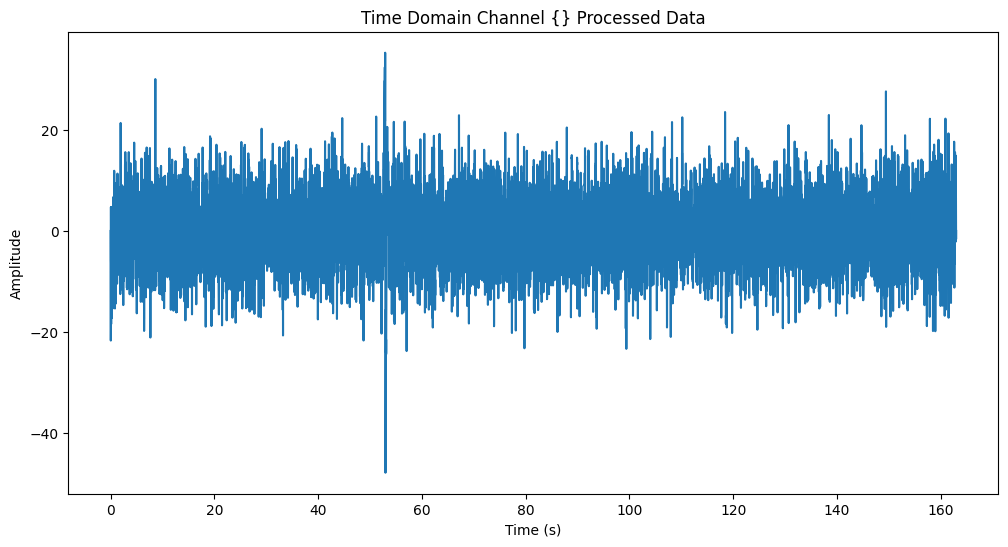

In [ ]:
# Временная характеристика
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(channel_data)) / raw.info['sfreq'], channel_data)
plt.title('Time Domain Channel {} Processed Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


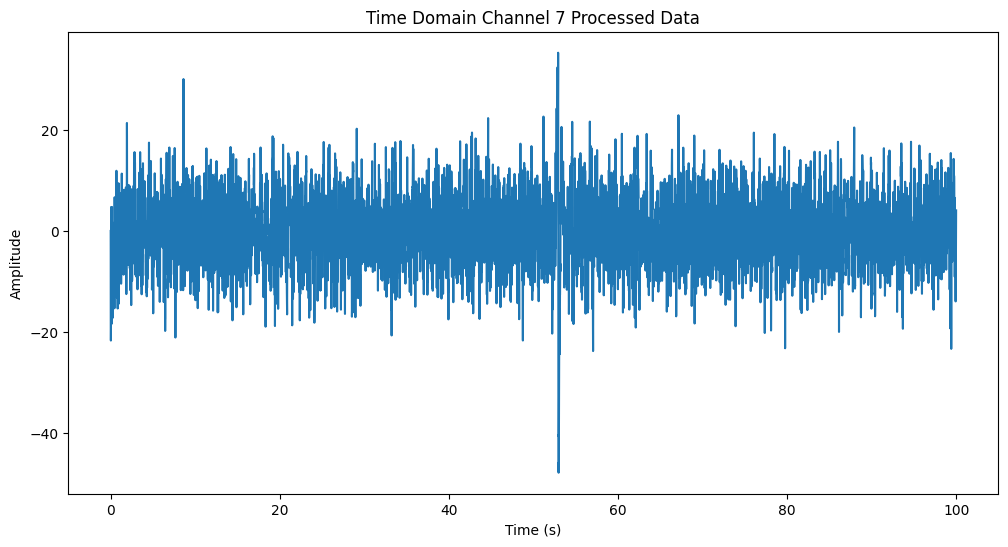

In [ ]:
# Установка границ времени для отображения данных
start_time = 0  # Начальное время в секундах
end_time = 100  # Конечное время в секундах

# Выделение соответствующего среза данных
time_slice = np.arange(int(start_time * raw.info['sfreq']), int(end_time * raw.info['sfreq']))
channel_data_slice = channel_data[time_slice]

# Временная характеристика
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(channel_data_slice)) / raw.info['sfreq'], channel_data_slice)
plt.title('Time Domain Channel 7 Processed Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()



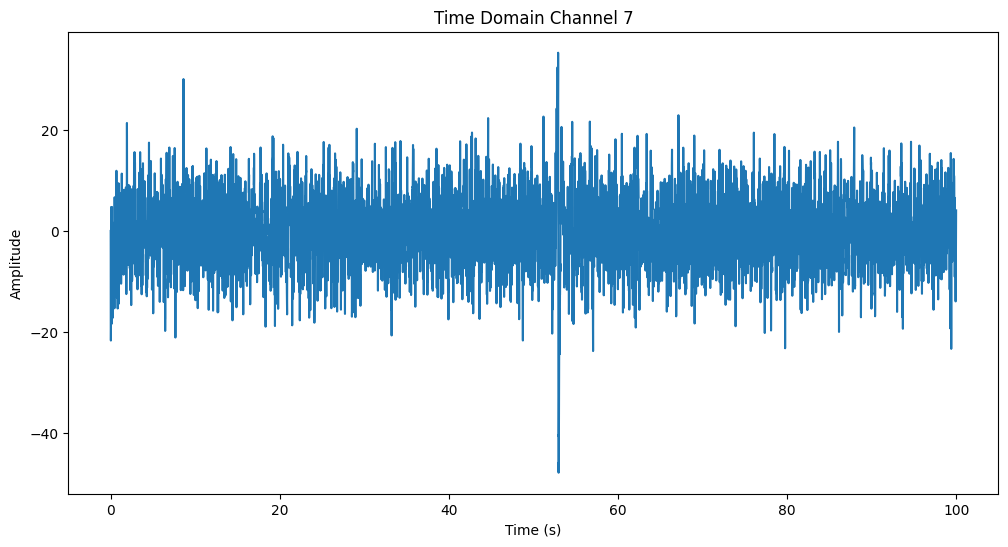

In [ ]:
# Установка границ времени для отображения данных
start_time = 0  # Начальное время в секундах
end_time = 100  # Конечное время в секундах

# Выделение соответствующего среза данных
time_slice = np.arange(int(start_time * raw.info['sfreq']), int(end_time * raw.info['sfreq']))
channel_data_slice = channel_data[time_slice]

# Временная характеристика
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(channel_data_slice)) / raw.info['sfreq'], channel_data_slice)
plt.title('Time Domain Channel 7')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

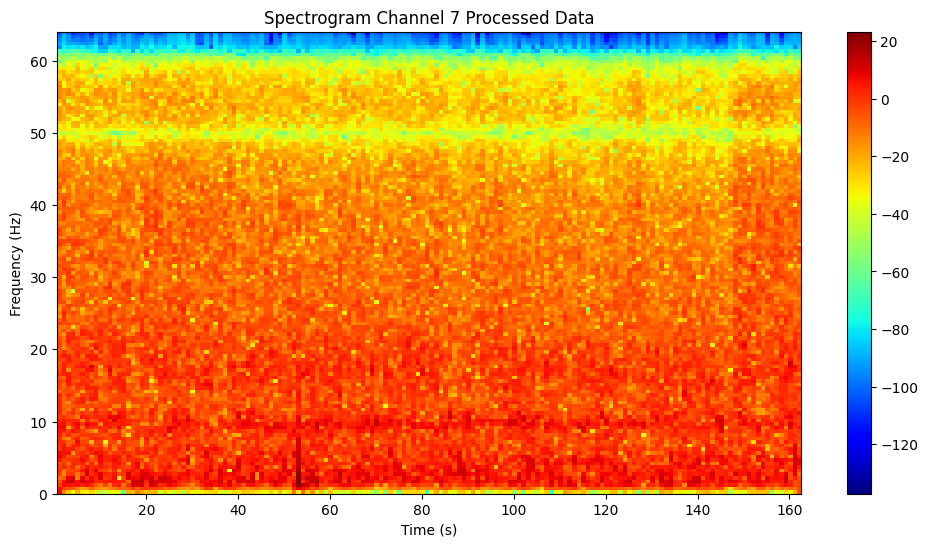

In [ ]:
# Частотно-временная характеристика
plt.figure(figsize=(12, 6))
plt.specgram(channel_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128, cmap='jet')
plt.title('Spectrogram Channel 7 Processed Data')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
# plt.ylim(0, 50)
plt.colorbar()
plt.show()
# # Частотно-временная характеристика
# plt.figure(figsize=(12, 6))
# Pxx, freqs, bins, im = plt.specgram(channel_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128, cmap='jet')
# plt.title('Spectrogram Channel 7 Original Data')
# plt.xlabel('Time (s)')
# plt.ylabel('Frequency (Hz)')
# plt.colorbar(im).set_label('Amplitude')
# plt.ylim(0, 50)  # Ограничение частотного диапазона до 50 Гц
# plt.show()


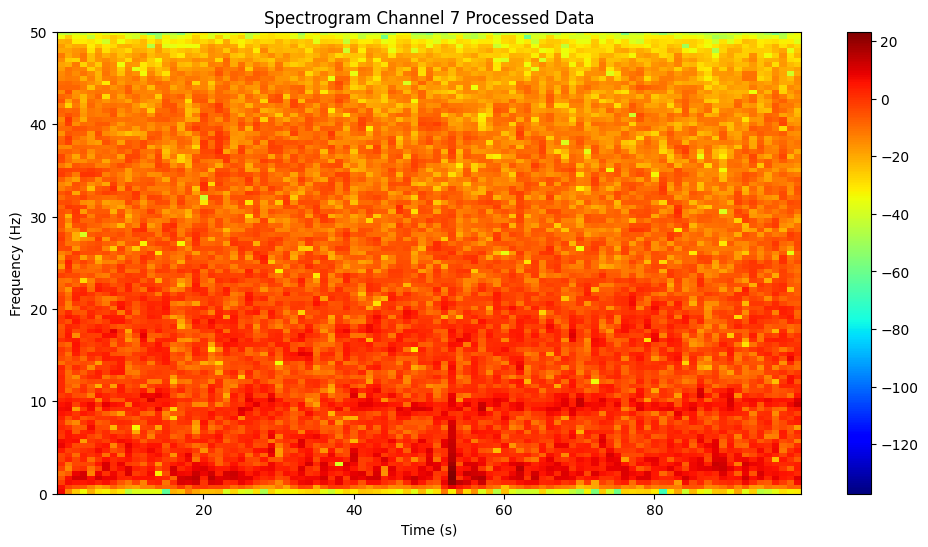

In [ ]:
# Установка границ времени для отображения данных
start_time = 0  # Начальное время в секундах
end_time = 100  # Конечное время в секундах

# Выделение соответствующего среза данных
time_slice = np.arange(int(start_time * raw.info['sfreq']), int(end_time * raw.info['sfreq']))
channel_data_slice = channel_data[time_slice]

# Частотно-временная характеристика
plt.figure(figsize=(12, 6))
plt.specgram(channel_data_slice, Fs=raw.info['sfreq'], NFFT=256, noverlap=128, cmap='jet')
plt.title('Spectrogram Channel 7 Processed Data')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.ylim(0, 50)
plt.show()


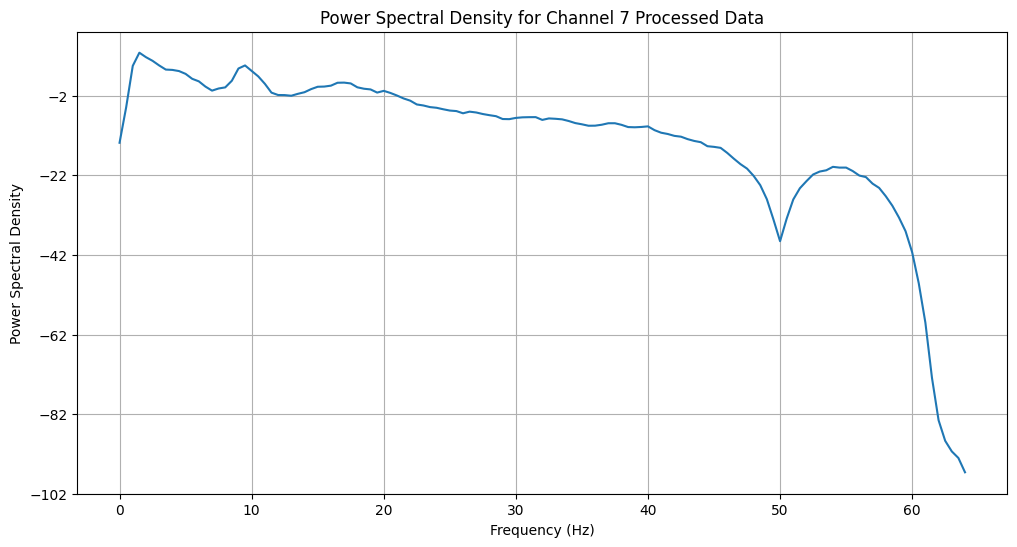

In [ ]:
plt.figure(figsize=(12, 6))
plt.psd(channel_data, Fs=raw.info['sfreq'], NFFT=256, noverlap=128)
plt.title('Power Spectral Density for Channel {} Processed Data'.format(channel_idx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.grid(True)
plt.show()

In [ ]:
fft_values = np.fft.fft(channel_data)
freq_values = np.fft.fftfreq(len(channel_data), d=1/raw.info['sfreq'])

plt.figure(figsize=(12, 6))
plt.plot(freq_values, np.abs(fft_values))
plt.title('Spectrum for Channel 7 Processed Data'.format(channel_idx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



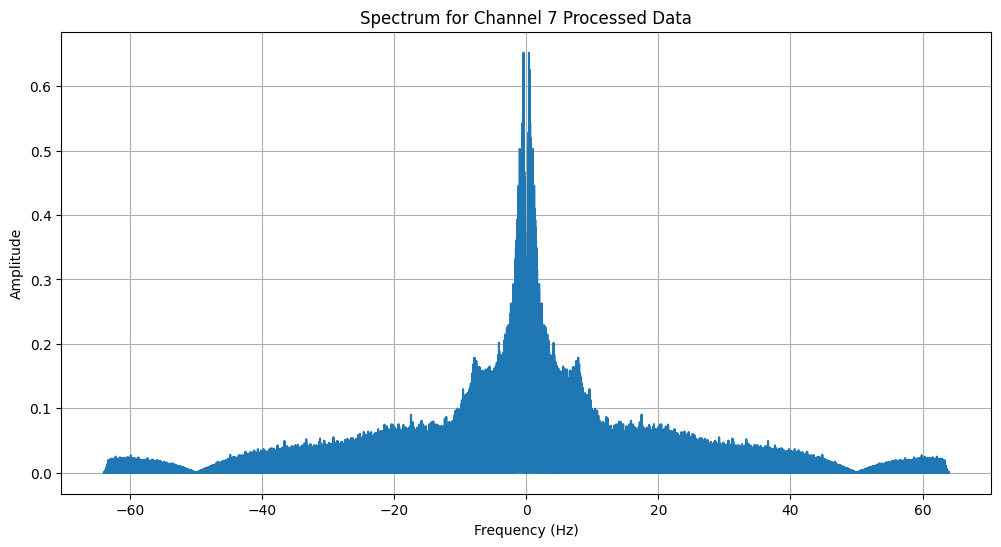

In [ ]:
fft_values = np.fft.fft(channel_data)
freq_values = np.fft.fftfreq(len(channel_data), d=1/raw.info['sfreq'])

plt.figure(figsize=(12, 6))
plt.plot(freq_values, np.abs(fft_values))
plt.title('Spectrum for Channel 7 Processed Data'.format(channel_idx))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



## старое

In [ ]:
# Нормализация данных
eeg_data_norm = (eeg_signals - eeg_signals.mean(axis=1, keepdims=True)) / eeg_signals.std(axis=1, keepdims=True)

# определяем вейвлет
wavelet = 'db4'

# применяем вейвлет-фильтрацию
coeffs = pywt.wavedec(eeg_data_norm, wavelet, level=6)
coeffs[1:] = [pywt.threshold(i, value=0, mode='soft') if i is not None else None for i in coeffs[1:]]
eeg_data_filt = pywt.waverec(coeffs, wavelet)

# фильтруем данные
eeg_data_filt = mne.filter.filter_data(eeg_data_filt, raw.info['sfreq'], l_freq=0.5, h_freq=30, verbose='ERROR')

info = mne.create_info(ch_names=raw.info['ch_names'], sfreq=raw.info['sfreq'], ch_types='eeg')
raw_filt = mne.io.RawArray(eeg_data_filt, info)

Creating RawArray with float64 data, n_channels=24, n_times=20864
    Range : 0 ... 20863 =      0.000 ...   162.992 secs
Ready.


## Построение до/после для всех сигналов

In [ ]:

# Спектры плотности мощности для всех каналов
plt.figure(figsize=(12, 6))
plt.psd(normalized_signal.T, Fs=raw.info['sfreq'], NFFT=256, noverlap=128)
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.grid(True)
plt.show()

NameError: ignored

<Figure size 1200x600 with 0 Axes>

In [ ]:
# построить исходные данные
plt.plot(eeg_signals.T)
plt.title('Before Filtering')
# по оси X отложено время, а по оси Y - амплитуда

# отобразить рисунок
plt.show()


In [ ]:
# построить исходные данные
plt.plot(eeg_data_norm.T)
plt.title('After normalization')
# по оси X отложено время, а по оси Y - амплитуда

# отобразить рисунок
plt.show()


In [ ]:
# построить отфильтрованные данные
plt.plot(eeg_data_filt.T)
plt.title('After Filtering')
# по оси X отложено время, а по оси Y - амплитуда

# отобразить рисунок
plt.show()

## Построение до/после для отдельных сигналов

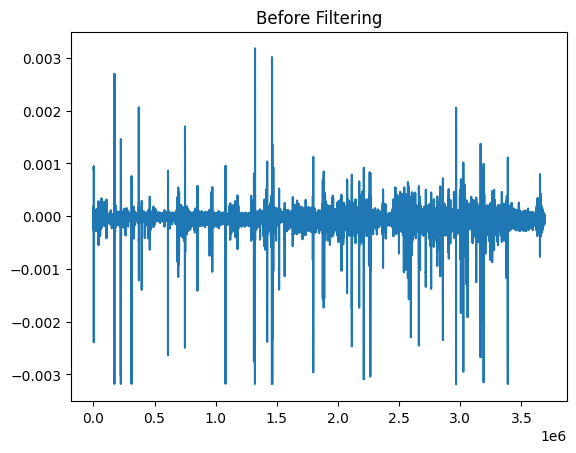

In [ ]:
single_eeg_signal = eeg_signals[0, :]
# построить данные
plt.plot(single_eeg_signal.T)
plt.title('Before Filtering')
# по оси X отложено время, а по оси Y - амплитуда

# отобразить рисунок
plt.show()

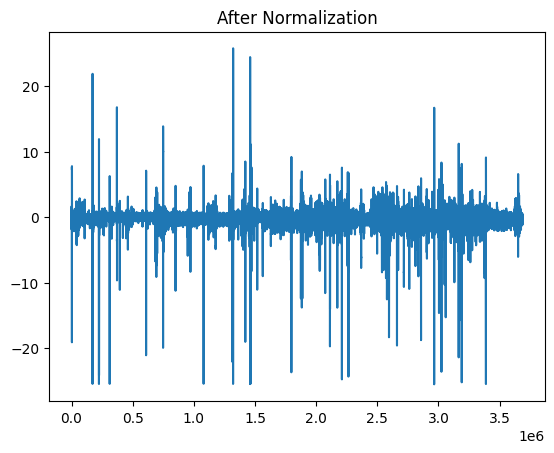

In [ ]:
single_eeg_norm = eeg_data_norm[0, :]
# построить данные
plt.plot(single_eeg_norm.T)
plt.title('After Normalization')
# по оси X отложено время, а по оси Y - амплитуда

# отобразить рисунок
plt.show()

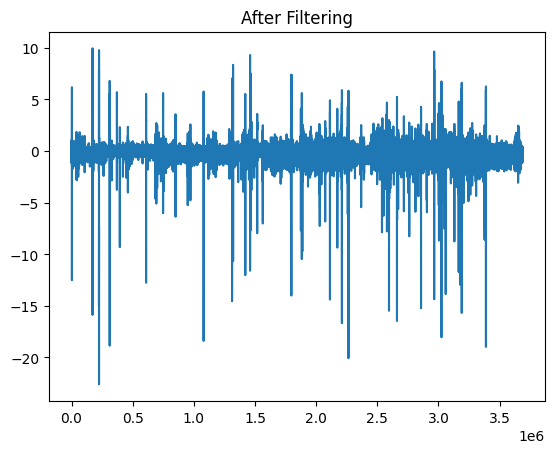

In [ ]:
single_eeg_filt = eeg_data_filt[0, :]
# построить данные
plt.plot(single_eeg_filt.T)
plt.title('After Filtering')
# по оси X отложено время, а по оси Y - амплитуда

# отобразить рисунок
plt.show()

In [ ]:
from mne.annotations import Annotations

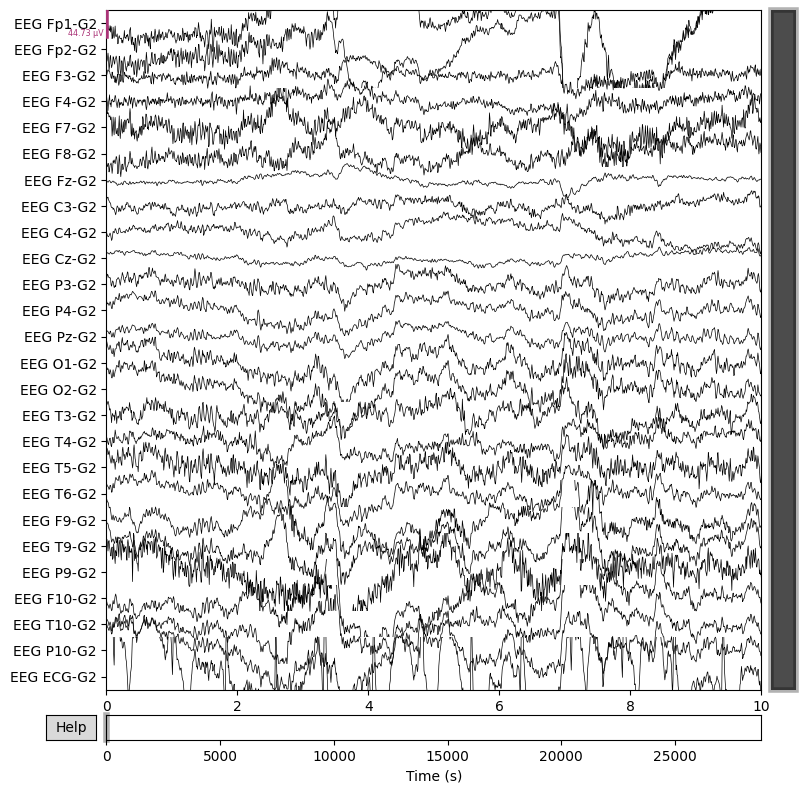

<RawEDF | EEG_80.edf, 26 x 3686528 (28801.0 s), ~731.3 MB, data loaded>

In [ ]:
plt.close()
fig = raw.plot(n_channels=len(raw.ch_names), scalings='auto', title='Before filtering')
raw.set_annotations(Annotations(onset=[0], duration=[1], description=['Before filtering']))

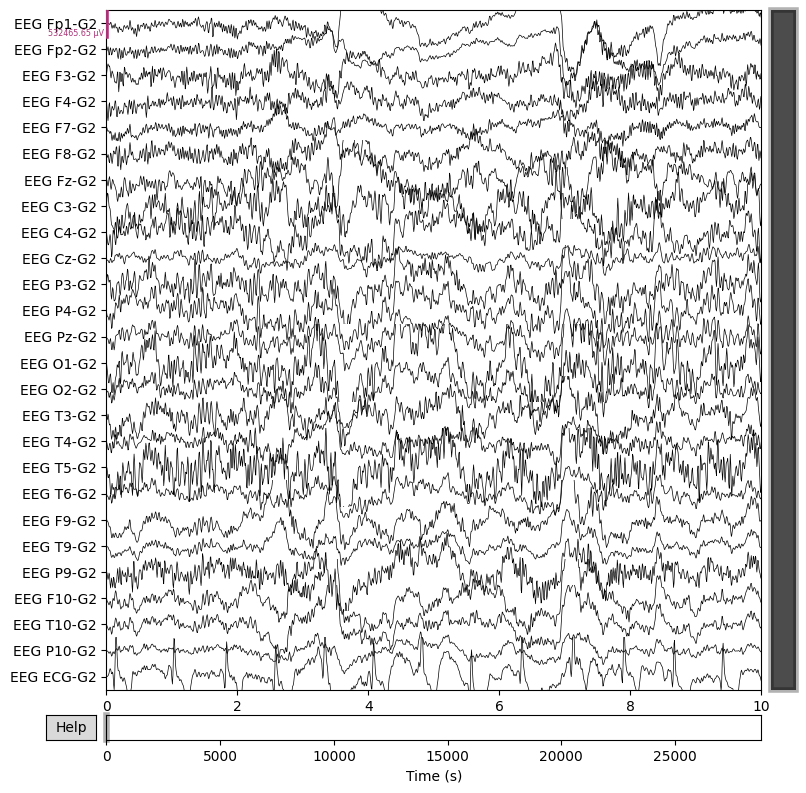

<RawArray | 26 x 3686528 (28801.0 s), ~731.3 MB, data loaded>

In [ ]:
plt.close()
fig = raw_filt.plot(n_channels=len(raw_filt.ch_names), scalings='auto', title='After filtering')
raw_filt.set_annotations(Annotations(onset=[0], duration=[1], description=['After filtering']))

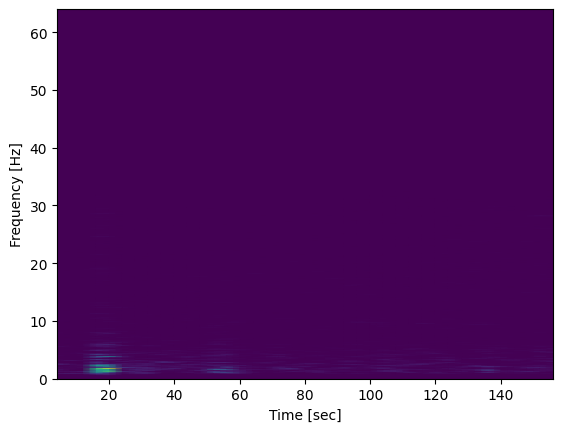

In [ ]:
from scipy import signal

# загрузка обработанного сигнала
signal_data = eeg_data_filt[1]

# определение параметров для построения спектрограммы
fs = raw.info['sfreq']  # частота дискретизации
nperseg = 1024 # длина окна
noverlap = nperseg // 2  # перекрытие окон
nfft = 2048  # количество точек для БПФ

# построение спектрограммы
frequencies, times, spectrogram = signal.spectrogram(signal_data, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

# отображение спектрограммы
plt.pcolormesh(times, frequencies, spectrogram, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


# Формирование обучающей выборки

In [ ]:
# длительность фрагмента в секундах
fragment_duration = 10

# количество отсчетов в каждом фрагменте
fragment_samples = int(fragment_duration * raw.info['sfreq'])

# список фрагментов сигнала ЭЭГ
eeg_fragments = []
for i in range(0, wavelet_filtered.shape[1], fragment_samples):
    fragment = wavelet_filtered[:, i:i+fragment_samples]
    eeg_fragments.append(fragment)


In [ ]:
for fragment in eeg_fragments:
    print(fragment.shape)


(24, 1280)
(24, 1280)
(24, 1280)
(24, 1280)
(24, 1280)
(24, 1280)
(24, 1280)
(24, 1280)
(24, 1280)
(24, 1280)
(24, 1280)
(24, 1280)
(24, 1280)
(24, 1280)
(24, 1280)
(24, 1280)
(24, 384)


In [ ]:
max_size = 1280
eeg_fragments = [np.pad(fragment, ((0, 0), (0, max_size - fragment.shape[1])), 'constant', constant_values=0) for fragment in eeg_fragments]


In [ ]:
eeg_fragments = np.array(eeg_fragments)

In [ ]:
print(eeg_fragments.shape)


(17, 24, 1280)


In [ ]:
# создание обучающей выборки
X_train = np.empty((0, fragment_samples))

X_train = np.array(eeg_fragments)


In [ ]:
print(X_train)

[[[-3.66373598e-15 -5.14103077e+00 -1.39659017e+01 ... -4.68066486e+00
   -3.97826942e+00 -5.84687550e+00]
  [-6.88338275e-15 -6.00469338e+00 -1.62977796e+01 ... -6.73710290e+00
   -5.99884226e+00 -6.14789055e+00]
  [-2.22044605e-16 -2.29051876e+00 -1.09867460e+01 ... -6.00059235e+00
   -4.73996166e+00 -2.72589240e+00]
  ...
  [-3.33066907e-16 -6.79695208e+00 -1.65998593e+01 ...  7.88338711e+00
    3.50849149e+00  2.24103801e+00]
  [ 1.44328993e-15 -7.74883088e+00 -1.81615346e+01 ...  8.20294904e+00
    1.72176256e+00  3.94088547e-01]
  [ 9.88098492e-15 -1.39221314e+01 -2.76188535e+01 ...  6.65090474e+00
    3.71895307e+00  6.72462814e+00]]

 [[-5.66377236e+00 -5.87130506e+00 -9.14618719e+00 ... -1.63026469e+00
   -2.57446569e+00  8.52954066e-01]
  [-5.87587953e+00 -4.36394139e+00 -6.26670618e+00 ... -1.04877283e+01
   -1.23392300e+01 -1.12259307e+01]
  [-1.48007221e+00 -3.16914994e+00 -7.10318928e+00 ...  2.36008983e+00
    2.65902574e+00  2.67729306e+00]
  ...
  [ 5.67726083e+00  4.0

# Модель автокодировщика

In [ ]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K


In [ ]:
# Размерность скрытого слоя (латентного пространства)
latent_dim = 2

input_shape = fragment.shape

# Определение кодировщика
input_data = Input(shape=input_shape)
encoder_layer_1 = Dense(128, activation='relu')(input_data)
encoder_layer_2 = Dense(64, activation='relu')(encoder_layer_1)
z_mean = Dense(latent_dim)(encoder_layer_2)
z_log_var = Dense(latent_dim)(encoder_layer_2)


In [ ]:
# Определение функции для оценки распределения в латентном пространстве
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


In [ ]:
# Определение декодировщика
decoder_layer_1 = Dense(64, activation='relu')(z)
decoder_layer_2 = Dense(128, activation='relu')(decoder_layer_1)
output_data = Dense(latent_dim, activation='sigmoid')(decoder_layer_2)


In [ ]:
# Определение модели VAE
vae = Model(input_data, output_data)


In [ ]:
from keras.losses import binary_crossentropy


In [ ]:
# Определение функции потерь
reconstruction_loss = binary_crossentropy(K.flatten(input_data), K.flatten(output_data))
reconstruction_loss *= input_shape
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss) + K.mean(kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
# Обучение модели на обучающей выборке
num_epochs = 10
batch_size = 384

vae.fit(X_train, epochs = 10, batch_size = 384)

Epoch 1/10


ValueError: ignored

In [ ]:
# Использование обученной модели для анализа новых данных
reconstructed_data = vae.predict(X_test)

NameError: ignored

In [ ]:
# Вычисление функции потерь на тестовых данных
loss = vae.evaluate(X_test)

NameError: ignored

In [ ]:
# Детектирование аномалий на основе функции потерь
threshold = np.mean(loss) + std_dev * np.std(loss)
anomalies = np.where(loss > threshold)[0]